<a href="https://colab.research.google.com/github/vanderbilt-ml/51-assign05-kprybol/blob/main/employee_churn_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [1]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [4]:
employee_df = pd.read_excel('IBM-HR-Data-Employee-Attrition.xlsx')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [6]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape

(1470, 35)

In [7]:
class_column = 'Attrition'
random_seed = 2435

#convert Attrition from Yes/No to 1/0 to work with XGBoost
employee_df['Attrition'] = employee_df['Attrition'].map({'No':0, 'Yes':1})



X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [8]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,1,1867,4,Male,91,2,5,Research Director,2,Married,19665,13583,4,Y,No,12,3,4,80,0,29,3,3,22,10,12,9
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,655,1,Female,66,2,1,Research Scientist,3,Divorced,2187,5013,0,Y,No,12,3,3,80,2,6,5,2,5,3,0,3
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,1,1932,3,Male,86,2,2,Research Scientist,4,Married,5747,26496,1,Y,Yes,15,3,2,80,0,16,3,3,15,10,6,11
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,1,804,3,Female,86,2,1,Research Scientist,1,Single,4381,7530,1,Y,No,11,3,3,80,0,6,3,3,6,5,1,3
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,1,193,4,Female,32,3,2,Research Scientist,3,Single,4317,2302,3,Y,Yes,20,4,2,80,0,19,2,3,3,2,2,2



On X test: 
X test dimensions:  (368, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,1,170,3,Female,96,3,2,Manufacturing Director,1,Married,6567,5549,1,Y,No,14,3,3,80,0,16,2,2,15,11,5,11
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,1,1583,2,Female,90,3,2,Sales Executive,2,Single,4198,16379,2,Y,No,12,3,2,80,0,8,5,4,3,2,1,2
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,1,1358,4,Male,67,3,1,Laboratory Technician,4,Married,3669,9075,3,Y,No,11,3,3,80,3,7,6,2,3,2,1,2
94,32,Travel_Rarely,1093,Sales,6,4,Medical,1,125,2,Male,87,3,2,Sales Executive,3,Single,5010,24301,1,Y,No,16,3,1,80,0,12,0,3,11,8,5,7


In [9]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    0
485     0
1368    0
579     0
142     0
Name: Attrition, dtype: int64


On y test: 
y test dimensions:  (368,)


129     0
1120    0
3       0
965     0
94      0
Name: Attrition, dtype: int64

In [10]:
X_train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [11]:
drop_cols = ['EmployeeNumber', 'EmployeeCount']

num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'PercentSalaryHike', 'MonthlyIncome',
                  'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
                  'YearsWithCurrManager', 'NumCompaniesWorked']

num_to_cat_cols = ['Education', 'JobLevel', 'StandardHours', 'StockOptionLevel', 'JobInvolvement', 
                   'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance', 'TrainingTimesLastYear']
                  
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

In [12]:
for col in num_cols:
    print(f'Column Name: {col}. Total Number of Unique Values: {len(X_train[col].unique())}')

Column Name: Age. Total Number of Unique Values: 43
Column Name: DailyRate. Total Number of Unique Values: 753
Column Name: DistanceFromHome. Total Number of Unique Values: 29
Column Name: HourlyRate. Total Number of Unique Values: 71
Column Name: PercentSalaryHike. Total Number of Unique Values: 15
Column Name: MonthlyIncome. Total Number of Unique Values: 1019
Column Name: TotalWorkingYears. Total Number of Unique Values: 40
Column Name: YearsAtCompany. Total Number of Unique Values: 35
Column Name: YearsInCurrentRole. Total Number of Unique Values: 19
Column Name: YearsSinceLastPromotion. Total Number of Unique Values: 16
Column Name: YearsWithCurrManager. Total Number of Unique Values: 18
Column Name: NumCompaniesWorked. Total Number of Unique Values: 10


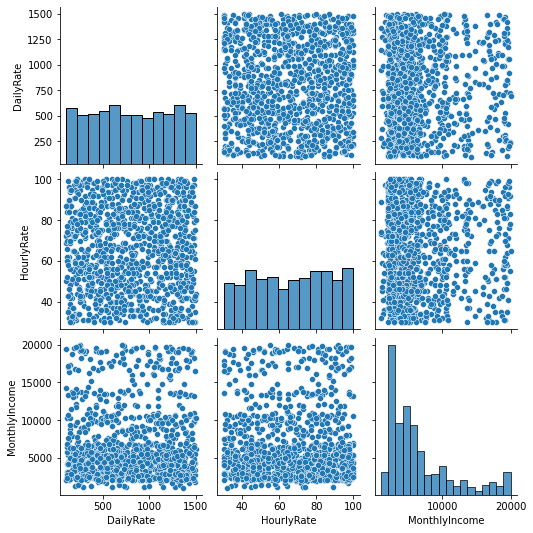

In [13]:
#check for collinearity
import seaborn as sns

sns.pairplot(X_train[['DailyRate', 'HourlyRate', 'MonthlyIncome']])

In [14]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# visually there doesn't appear to any concerns around multicollinearity of income variable, but will check just in case. 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train[['DailyRate', 'HourlyRate', 'MonthlyIncome']].columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train[['DailyRate', 'HourlyRate', 'MonthlyIncome']].values, i)
                          for i in range(len(X_train[['DailyRate', 'HourlyRate', 'MonthlyIncome']].columns))]
  
print(vif_data)

         feature       VIF
0      DailyRate  3.808627
1     HourlyRate  4.556747
2  MonthlyIncome  2.582451


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
for col in num_to_cat_cols:
    print(f'Column Name: {col}. Total Number of Unique Values: {len(X_train[col].unique())}')

Column Name: Education. Total Number of Unique Values: 5
Column Name: JobLevel. Total Number of Unique Values: 5
Column Name: StandardHours. Total Number of Unique Values: 1
Column Name: StockOptionLevel. Total Number of Unique Values: 4
Column Name: JobInvolvement. Total Number of Unique Values: 4
Column Name: JobSatisfaction. Total Number of Unique Values: 4
Column Name: PerformanceRating. Total Number of Unique Values: 2
Column Name: RelationshipSatisfaction. Total Number of Unique Values: 4
Column Name: WorkLifeBalance. Total Number of Unique Values: 4
Column Name: TrainingTimesLastYear. Total Number of Unique Values: 7


In [17]:
for col in cat_cols:
    print(f'Column Name: {col}. Total Number of Unique Values: {len(X_train[col].unique())}')

Column Name: BusinessTravel. Total Number of Unique Values: 3
Column Name: Department. Total Number of Unique Values: 3
Column Name: EducationField. Total Number of Unique Values: 6
Column Name: Gender. Total Number of Unique Values: 2
Column Name: JobRole. Total Number of Unique Values: 9
Column Name: MaritalStatus. Total Number of Unique Values: 3
Column Name: Over18. Total Number of Unique Values: 1
Column Name: OverTime. Total Number of Unique Values: 2


## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [18]:
# TODO: establish your own pipelines for the different data types
cat_cols = cat_cols + num_to_cat_cols

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [19]:
# TODO: establish your preprocessing pipeline by your feature set

In [20]:
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols),
                             ('num_pipe', num_pipeline, num_cols)],
                             remainder='drop')

In [21]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# TODO: set up your modeling pipeline

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [32]:
# TODO: set up your tuning grid 
import xgboost as xgb

clf1 = LogisticRegression(solver='liblinear', random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = xgb.XGBRegressor(objective='binary:logistic', eval_metric='auc', verbosity=1)

pipeline = Pipeline([('preprocessor', preproc), ('classifier', clf1)])

params1 = {}
params1['classifier__penalty'] = ['l1', 'l2']
params1['classifier__C'] = [0.1, 1, 10]
params1['classifier'] = [clf1]

params2 = {}
params2['classifier__n_estimators'] = [100, 200]
params2['classifier__min_samples_leaf'] = [1, 2]
params2['classifier'] = [clf2]

params3 = {}
params3['classifier__max_depth'] = [5,7,9]
params3['classifier__eta'] = [0.01,0.04]
params3['classifier__lambda'] = [0.001, 0.1]
params3['classifier__alpha'] = [0.001, 0.1]
params3['classifier__tree_method'] = ['gpu_hist']
params3['classifier'] = [clf3]

params = [params1, params2, params3]

grid = GridSearchCV(pipeline, params, verbose=10)

In [ ]:
# TODO: fit your model

grid.fit(X_train, y_train)
grid.best_params_

## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [37]:
# TODO: print your best estimator (pipeline)
display(pipeline)
display(grid.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime',
                                                   'Education', 'JobLevel',
                                                   'StandardHours',
                      

{'classifier': LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'),
 'classifier__C': 1,
 'classifier__penalty': 'l1'}

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [42]:
# TODO: feel free to print out the target classes
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime',
                                                   'Education', 'JobLevel',
                                                   'StandardHours',
                      

In [43]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = grid.best_estimator_['classifier'].coef_[0]
vip

array([-1.22248628,  0.6491561 , -0.16911752,  0.        , -0.71242159,
        0.        ,  0.        , -0.42622805,  0.        , -0.3105372 ,
       -0.57522997,  0.4260756 ,  0.31815619,  0.        ,  0.        ,
        0.79483706,  0.        ,  0.        , -0.48970285, -0.15372019,
        0.36711837,  0.23567822, -0.41205824, -0.3009939 ,  0.01428668,
       -0.45526141,  1.95587916, -0.08129818,  0.        ,  0.        ,
        0.05243756, -0.08068142,  0.        , -1.09546007,  0.        ,
       -0.60055117,  0.        , -0.27769809,  0.03143501, -1.0266607 ,
       -0.73620315,  0.        ,  0.74082592,  0.        , -0.31021073,
       -1.24935345,  0.48294008, -0.10715839,  0.        , -0.8790441 ,
       -0.0914147 ,  0.60654763,  0.        , -0.14178634, -0.11085604,
        1.18493426,  0.        , -0.54286541, -0.04936087,  1.4453325 ,
        0.00358767, -0.03673885, -0.29149053,  0.10856219, -0.00302107,
       -0.45102459, -0.35795803, -0.20979782,  0.40113894,  0.03

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


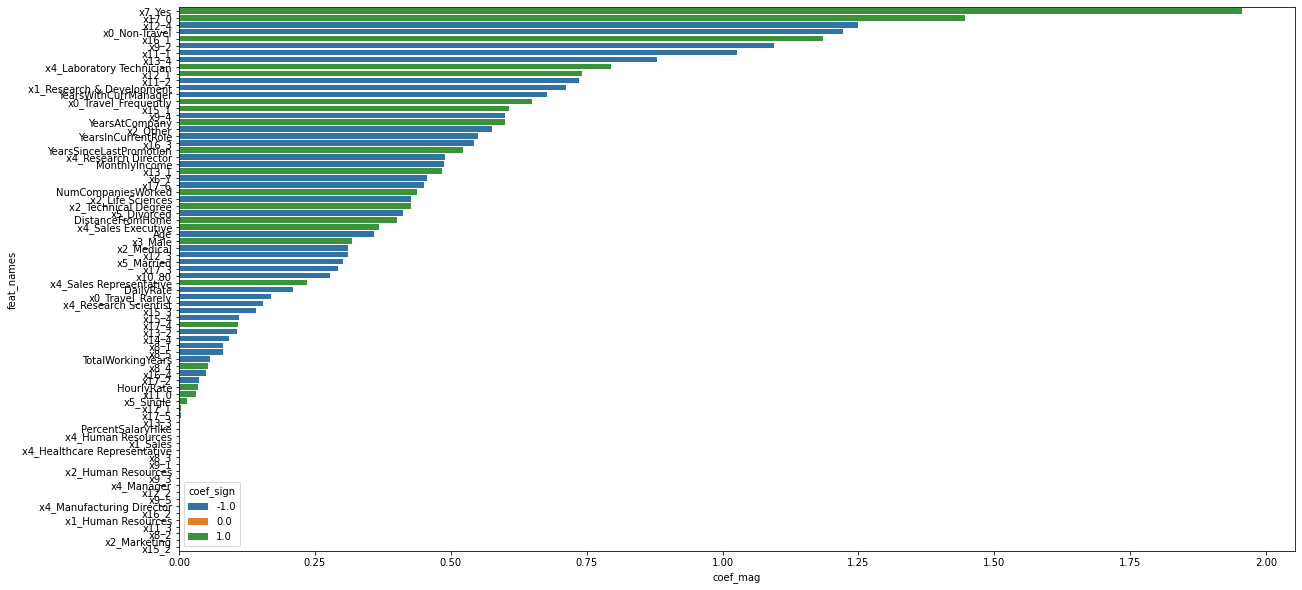

In [45]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

# #get names in correct preproc order
cat_names = grid.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid.best_estimator_.named_steps['preprocessor'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [47]:
# TODO: print your classification report of your model
print(classification_report(y_test, grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       309
           1       0.61      0.46      0.52        59

    accuracy                           0.87       368
   macro avg       0.76      0.70      0.72       368
weighted avg       0.86      0.87      0.86       368



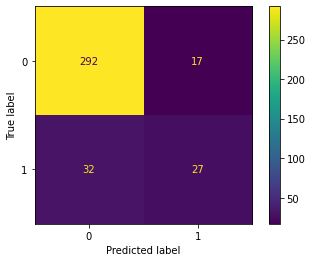

In [48]:
# TODO: plot the confusion matrix graph
cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()